In [1]:
# !pip install kaggle

In [2]:
# from google.colab import files
# files.upload()

In [3]:
# ! mkdir ~/.kaggle

In [4]:
# ! cp kaggle.json ~/.kaggle/

In [5]:
# ! chmod 600 ~/.kaggle/kaggle.json

In [6]:
# ! kaggle datasets list

In [7]:
! kaggle datasets download -d chetankv/dogs-cats-images

 96% 419M/435M [00:01<00:00, 248MB/s]
100% 435M/435M [00:01<00:00, 237MB/s]


In [7]:
# ! unzip dogs-cats-images.zip

### Packages

In [9]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread

### Préparer l'ensemble de données

In [10]:
# Chemin d'accès du dossier dogs_vs_cats
my_data_dir = 'dataset'
os.listdir(my_data_dir)

['training_set', 'test_set']

In [11]:
train_path = my_data_dir+'/training_set/'
test_path = my_data_dir+'/test_set/'

In [12]:
os.listdir(train_path)

['dogs', 'cats']

In [13]:
os.listdir(test_path)

['dogs', 'cats']

### Visualisation

In [14]:
os.listdir(train_path+'cats')[0]

'cat.324.jpg'

In [15]:
cat_animal = train_path+'/cats'+'/cat.324.jpg'

In [16]:
cat_img = imread(cat_animal)

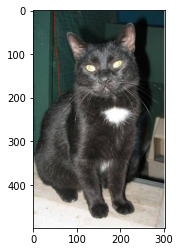

In [17]:
plt.imshow(cat_img);

In [18]:
cat_img.shape

(499, 302, 3)

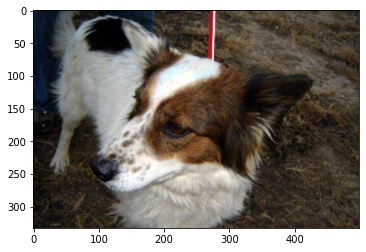

In [19]:
dog_path = train_path+'dogs/'+os.listdir(train_path+'/dogs')[0]
dog_img = imread(dog_path)
plt.imshow(dog_img);

In [20]:
dog_img.shape

(333, 499, 3)

### Vérifions combien d'images il y a.

In [21]:
len(os.listdir(train_path+'cats')), len(os.listdir(train_path+'dogs'))

(4000, 4000)

### Découvrons les dimensions moyennes de ces images.

In [22]:
dim1 = []
dim2 = []
for image_filename in os.listdir(train_path+'cats'):
    
    img = imread(train_path+'cats'+'/'+image_filename)
    d1,d2,colors = img.shape
    dim1.append(d1)
    dim2.append(d2)

In [23]:
np.mean(dim1)

356.09925

In [24]:
np.mean(dim2)

409.61975

In [26]:
image_shape = (150,150,3)

### Manipulation des images
- C'est généralement une bonne idée de manipuler les images avec une rotation, un redimensionnement et une mise à l'échelle afin que le modèle devienne plus robuste aux différentes images que notre ensemble de données n'a pas. Nous pouvons utiliser le générateur ImageDataGenerator pour le faire automatiquement pour nous

In [27]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
image_gen = ImageDataGenerator(rotation_range=20, # Faire pivoter l'image de 20 degrés 
                               rescale=1.0/255,
                               shear_range=0.1,
                               zoom_range=0.1,
                               fill_mode='nearest',
                               horizontal_flip=True
                              )

- Génération de nombreuses images

In [28]:
image_gen.flow_from_directory(train_path)

Found 8000 images belonging to 2 classes.


In [29]:
image_gen.flow_from_directory(test_path)

Found 2000 images belonging to 2 classes.


### Création du Modèle

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

In [31]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())


model.add(Dense(128))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18496)             0

### Early Stopping

In [34]:
from tensorflow.keras.callbacks import EarlyStopping

In [35]:
early_stop = EarlyStopping(monitor='val_loss',patience=10)

### Entraînement du Modèle

In [36]:
batch_size = 32

In [37]:
train_image_gen = image_gen.flow_from_directory(train_path,
                                               target_size=image_shape[:2],
                                                color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary')

Found 8000 images belonging to 2 classes.


In [38]:
test_image_gen = image_gen.flow_from_directory(test_path,
                                               target_size=image_shape[:2],
                                               color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary',shuffle=False)

Found 2000 images belonging to 2 classes.


In [39]:
train_image_gen.class_indices

{'cats': 0, 'dogs': 1}

In [40]:
results = model.fit(train_image_gen,epochs=30,
                              validation_data=test_image_gen,
                             callbacks=[early_stop])

Epoch 1/30
250/250 [==============================] - 101s 272ms/step - loss: 0.7016 - accuracy: 0.5065 - val_loss: 0.6597 - val_accuracy: 0.6070
Epoch 2/30
250/250 [==============================] - 68s 271ms/step - loss: 0.6519 - accuracy: 0.6252 - val_loss: 0.5822 - val_accuracy: 0.6950
Epoch 3/30
250/250 [==============================] - 68s 270ms/step - loss: 0.5887 - accuracy: 0.6861 - val_loss: 0.5367 - val_accuracy: 0.7375
Epoch 4/30
250/250 [==============================] - 67s 269ms/step - loss: 0.5424 - accuracy: 0.7334 - val_loss: 0.5089 - val_accuracy: 0.7650
Epoch 5/30
250/250 [==============================] - 67s 269ms/step - loss: 0.5074 - accuracy: 0.7592 - val_loss: 0.5111 - val_accuracy: 0.7635
Epoch 6/30
250/250 [==============================] - 68s 270ms/step - loss: 0.4831 - accuracy: 0.7722 - val_loss: 0.4744 - val_accuracy: 0.7770
Epoch 7/30
250/250 [==============================] - 67s 269ms/step - loss: 0.4601 - accuracy: 0.7878 - val_loss: 0.4471 - val_a

In [44]:
from tensorflow.keras.models import load_model
model.save('cat_vs_dog_conv2d.h5')

### Évaluation du Modèle

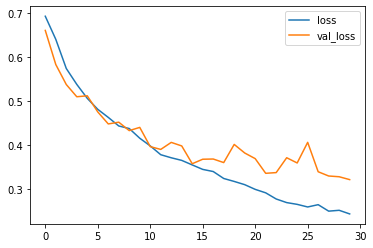

In [41]:
losses = pd.DataFrame(model.history.history)
losses[['loss','val_loss']].plot()

In [42]:
model.metrics_names

['loss', 'accuracy']

In [43]:
model.evaluate(test_image_gen)

63/63 [==============================] - 13s 209ms/step - loss: 0.3288 - accuracy: 0.8670


[0.32875341176986694, 0.8669999837875366]

In [45]:
from tensorflow.keras.preprocessing import image

In [47]:
pred_probabilities = model.predict(test_image_gen)
pred_probabilities

array([[0.36441138],
       [0.6177677 ],
       [0.01291595],
       ...,
       [0.07486376],
       [0.86867565],
       [0.9997689 ]], dtype=float32)

In [48]:
predictions = pred_probabilities > 0.5

In [49]:
from sklearn.metrics import classification_report,confusion_matrix

In [50]:
print(classification_report(test_image_gen.classes,predictions))

              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1000
           1       0.89      0.82      0.86      1000

    accuracy                           0.86      2000
   macro avg       0.86      0.86      0.86      2000
weighted avg       0.86      0.86      0.86      2000

